# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [9]:
DEVICE = 'cuda:0'
NDIM = 3 # number of parameters
NBINS = 1000

In [18]:
SIGMA = 0.1
def model(z, w = 0.03):
    grid = np.linspace(0, 1, 32, 32)
    X, Y = np.meshgrid(grid, grid)
    x1, y1, r = z[0], z[1], z[2]*0.5
    R1 = ((X-x1)**2 + (Y-y1)**2)**0.5
    mu = np.exp(-(R1-r)**2/w**2/2)
    x = mu
    return x

def noisemodel(x, z = None):
    n = np.random.randn(*x.shape)*SIGMA  #*noiselevel
    return x + n

In [4]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, 3)
        self.conv2 = torch.nn.Conv2d(10, 20, 3)
        self.conv3 = torch.nn.Conv2d(20, 40, 3)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

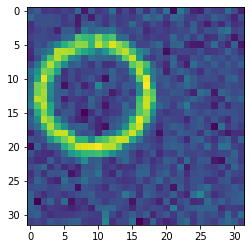

In [5]:
z0 = np.array([0.3, 0.4, .5])
x0 = noisemodel(model(z0))
plt.imshow(x0)

In [6]:
ds = swyft.DataStoreZarr("/home/aecole/swyft/notebooks/ring3.zarr")
ds.init(zdim = 3, xdim = (32, 32))

Creating empty datastore: /home/aecole/swyft/notebooks/ring3.zarr
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


In [7]:
sw_list = []

for i_round in range(6):
    parent = None if len(sw_list) == 0 else sw_list[-1]
    sw = swyft.SWYFT(x0, zdim = 3, device = DEVICE, head = Head, datastore = ds, nsamples = 2000, noisemodel = noisemodel, parent = parent)
    sw_list.append(sw)
    
    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)
            
    sw.train1d(max_epochs = 100, nbatch = 16)

Constrained posterior area: 1.0
Adding 2025 new samples. Run simulator!
Number of output features: 160
Start training
LR iteration 0
Total epochs: 18
Validation losses: [6.817079320549965, 6.103459075093269, 5.660861819982529, 5.44215352833271, 5.306291118264198, 5.030347220599651, 5.149094924330711, 4.771672785282135, 4.697712607681751, 4.955874763429165, 4.512130595743656, 4.55534715950489, 4.626527331769466, 4.379454217851162, 4.187870100140572, 4.92352119833231, 4.977155581116676, 4.3076244704425335]
LR iteration 1
Total epochs: 5
Validation losses: [3.9205062724649906, 3.8190887048840523, 3.884276367723942, 4.004568610340357, 3.930109601467848]
LR iteration 2
Total epochs: 10
Validation losses: [3.841625887900591, 3.862337812781334, 3.906685385853052, 3.8268525823950768, 3.911148153245449, 3.870438389480114, 3.777038749307394, 3.88499803096056, 3.874669637531042, 3.8848994076251984]
Constrained posterior area: 0.09694973
Adding 1826 new samples. Run simulator!
Number of output fea

In [29]:
ds.__len__()

10960

In [19]:
grad = []
for i in range(0, NDIM):
    dz = np.zeros(NDIM)
    d = 0.001
    dz[i] += d
    g = (model(z0+dz) - model(z0))/d
    grad.append(g)

I = np.zeros((NDIM, NDIM))

for i in range(NDIM):
    for j in range(NDIM):
        I[i, j] = (grad[i]*grad[j]).sum()/SIGMA**2
        
Cov = np.linalg.inv(I)
err = np.diag(Cov)**0.5
print(err)

[0.00067007 0.00066999 0.00094704]


In [22]:
mn=[]
mn.append([0.30210,0.30210-0.00069,0.30210+0.00069])
mn.append([0.39985,0.39985-0.00064,0.39985+0.00064])
mn.append([0.49979,0.49979-0.00093,0.49979+0.00093])

1.2471205365577909 2.4438901380487095
1.1831396489371546 2.234367617364524
1.165648380754786 2.287409116048384


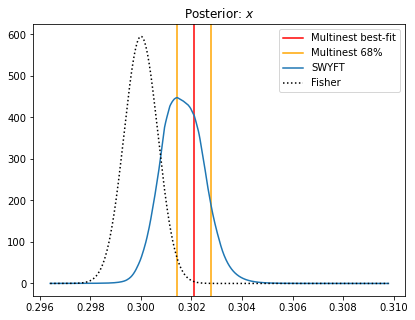

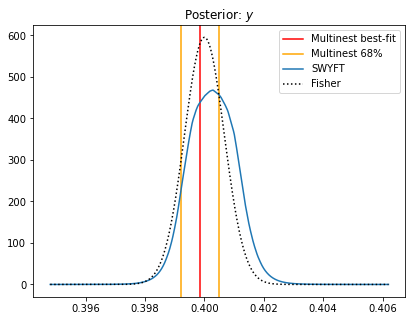

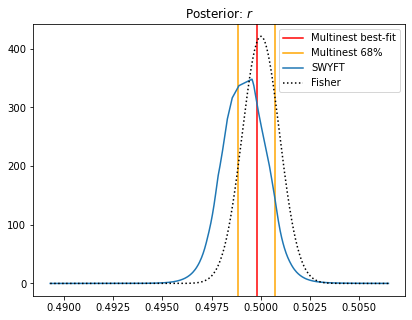

In [51]:
#plt.figure(figsize=(20, 5))
pList=["$x$",'$y$','$r$']
for i in range(3):
    plt.figure(figsize=(20/3,5))
    z, p = sw_list[-1].posterior(i)
    #plt.axvline(z0[i])
    plt.axvline(mn[i][0],color='red',label='Multinest best-fit')
    plt.axvline(mn[i][1],color='orange', label='Multinest 68%')
    plt.axvline(mn[i][2],color='orange')
    plt.plot(z, p,label='SWYFT')
    plt.plot(z, stats.norm.pdf(z, z0[i], err[i]), 'k:',label='Fisher')
    plt.title('Posterior: '+pList[i])
    plt.legend()
    s = swyft.get_stats(z, p)
    print(s['err68']/err[i], s['err95']/err[i])

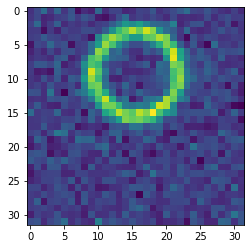

In [33]:
z1 = np.array([0.5, 0.3, .4])
x1 = noisemodel(model(z1))
plt.imshow(x1)

In [34]:
sw2_list = []

for i_round in range(6):
    parent = None if len(sw2_list) == 0 else sw2_list[-1]
    sw2 = swyft.SWYFT(x1, zdim = 3, device = DEVICE, head = Head, datastore = ds, nsamples = 2000, noisemodel = noisemodel, parent = parent)
    sw2_list.append(sw2)
    
    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)
            
    sw2.train1d(max_epochs = 100, nbatch = 16)

Constrained posterior area: 1.0
No new simulator runs required.
Number of output features: 160
Start training
LR iteration 0
Total epochs: 15
Validation losses: [7.290298193693161, 6.24522040784359, 5.793163701891899, 5.549760013818741, 5.249885708093643, 5.122813791036606, 5.06828685849905, 4.937433630228043, 5.1528849974274635, 4.886505462229252, 4.651920855045319, 4.592245556414127, 4.981209382414818, 5.3206860944628716, 4.661384716629982]
LR iteration 1
Total epochs: 6
Validation losses: [4.298265308141708, 4.282097049057484, 4.2697439305484295, 4.323567848652601, 4.394190415740013, 4.3513176664710045]
LR iteration 2
Total epochs: 4
Validation losses: [4.3181559927761555, 4.351561367511749, 4.358172122389078, 4.3568142503499985]
Constrained posterior area: 0.1281883
Adding 1577 new samples. Run simulator!
Number of output features: 160
Start training
LR iteration 0
Total epochs: 20
Validation losses: [6.237997621297836, 4.541155859827995, 3.9253618866205215, 3.992288313806057, 3.66

In [35]:
ds.__len__()

18619

In [36]:
grad = []
for i in range(0, NDIM):
    dz = np.zeros(NDIM)
    d = 0.001
    dz[i] += d
    g = (model(z1+dz) - model(z1))/d
    grad.append(g)

I = np.zeros((NDIM, NDIM))

for i in range(NDIM):
    for j in range(NDIM):
        I[i, j] = (grad[i]*grad[j]).sum()/SIGMA**2
        
Cov = np.linalg.inv(I)
err2 = np.diag(Cov)**0.5
print(err2)

[0.0007483  0.00074859 0.00105781]


In [44]:
mn2=[]
mn2.append([0.50033,0.50033-0.00077,0.50033+0.00077])
mn2.append([0.29974,0.29974-0.00074,0.29974+0.00074])
mn2.append([0.4001,0.4001-0.0010,0.4001+0.0010])

1.2215608384998424 2.350380292030794
1.1136973335390967 2.175427440107522
1.1462539616563887 2.277476307742467


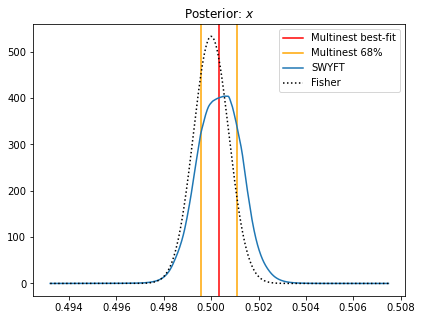

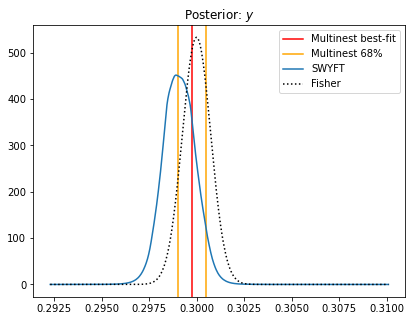

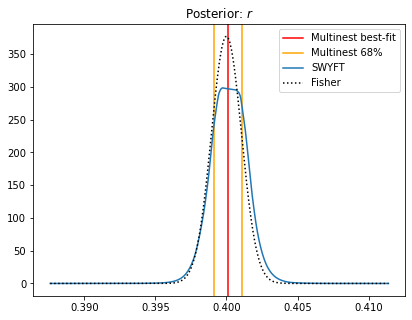

In [50]:
#plt.figure(figsize=(20, 5))
pList=["$x$",'$y$','$r$']
for i in range(3):
    plt.figure(figsize=(20/3,5))
    z, p = sw2_list[-1].posterior(i)
    #plt.axvline(z0[i])
    plt.axvline(mn2[i][0],color='red',label='Multinest best-fit')
    plt.axvline(mn2[i][1],color='orange')
    plt.axvline(mn2[i][2],color='orange',label='Multinest 68%')
    plt.plot(z, p,label='SWYFT')
    plt.plot(z, stats.norm.pdf(z, z1[i], err2[i]), 'k:',label='Fisher')
    plt.title('Posterior: '+pList[i])
    plt.legend()
    s = swyft.get_stats(z, p)
    print(s['err68']/err2[i], s['err95']/err2[i])